In [1]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import pickle
import datetime
import platform
import gala
import astropy

from gala.units import galactic
from gala.potential import Hamiltonian
from gala.potential import LogarithmicPotential
from gala.dynamics import PhaseSpacePosition
from gala.dynamics.mockstream import (
    MockStreamGenerator,
    FardalStreamDF
)

from tqdm.notebook import tqdm
import time
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def save_streams(streams, filename="streams.pkl"):
    """
    Save stream ensemble with metadata for reproducibility.
    """
    payload = {
        "streams": streams,
        "metadata": {
            "created": datetime.datetime.now().isoformat(),
            "python_version": platform.python_version(),
            "gala_version": gala.__version__,
            "astropy_version": astropy.__version__,
            "description": "GC streams in axisymmetric halo potentials"
        }
    }

    with open(filename, "wb") as f:
        pickle.dump(payload, f)

    print(f"Saved {len(streams)} streams to {filename}")

In [3]:
def make_galactic_hamiltonian(q=1.0):
    pot = LogarithmicPotential(
        v_c=220 * u.km/u.s,
        r_h=12 * u.kpc,
        q1=1.0,
        q2=1.0,
        q3=q,
        units=galactic
    )
    return Hamiltonian(pot)

In [4]:
def make_time_array(t_backward=4 * u.Gyr, dt=1 * u.Myr):
    """
    Create a backward time array for orbit and stream integration.
    """
    t = np.arange(
        0,
        -t_backward.to_value(u.Myr),
        -dt.to_value(u.Myr)
    ) * u.Myr
    return t

In [5]:
def initial_progenitor_phase_space():
    """
    Initial phase-space position of the progenitor globular cluster.
    """
    pos = [8.5, 0.0, 5.0] * u.kpc
    vel = [0.0, 180.0, 60.0] * u.km/u.s
    return PhaseSpacePosition(pos=pos, vel=vel)

In [6]:
def integrate_progenitor_orbit(hamiltonian, w0, t):
    """
    Integrate the progenitor orbit over the given time array.
    """
    orbit = hamiltonian.integrate_orbit(w0, t=t)
    return orbit

In [7]:
def generate_stream(
    hamiltonian,
    w0,
    t,
    progenitor_mass=1e4 * u.Msun,
    n_particles=1500,
):
    """
    Generate a stellar stream using a particle-spray model.
    
    Progenitor physics:
        - encoded via progenitor mass (tidal stripping)
    Galactic dynamics:
        - encoded via Hamiltonian
    """

    # Fardal (2015) DF, gala-modified parameters
    df = FardalStreamDF(gala_modified=True)

    generator = MockStreamGenerator(df, hamiltonian)

    stream = generator.run(
        w0,
        prog_mass=progenitor_mass,
        n_particles=n_particles,
        t=t
    )

    return stream

In [8]:
def run_experiment(
    t_backward=4 * u.Gyr,
    dt=1 * u.Myr,
    n_particles=1500,
):
    halo_shapes = {
        "spherical": 1.0,
        "oblate": 0.8,
        "prolate": 1.2
    }

    progenitor_masses = [
        8e3 * u.Msun,
        1e4 * u.Msun,
        2e4 * u.Msun,
    ]

    # Shared initial conditions
    w0 = initial_progenitor_phase_space()
    t = make_time_array(t_backward=t_backward, dt=dt)

    total_streams = len(halo_shapes) * len(progenitor_masses)
    streams = []

    with tqdm(
        total=total_streams,
        desc="Generating stellar streams",
        mininterval=0.5
    ) as pbar:

        for halo_name, q in halo_shapes.items():
            H = make_galactic_hamiltonian(q=q)

            # Integrate progenitor orbit ONCE per halo
            orbit = integrate_progenitor_orbit(H, w0, t)

            for i, mass in enumerate(progenitor_masses):

                print(
                    f"Starting stream: halo={halo_name}, "
                    f"M={mass.value:.1e} Msun",
                    flush=True
                )

                start = time.time()

                stream = generate_stream(
                    H,
                    w0=w0,
                    t=t,
                    progenitor_mass=mass,
                    n_particles=n_particles
                )

                elapsed = time.time() - start

                streams.append({
                    "halo": halo_name,
                    "q": q,
                    "progenitor_id": i,
                    "mass": mass,
                    "stream": stream,
                    "orbit": orbit,
                    "t": t
                })

                pbar.update(1)
                pbar.set_postfix({
                    "halo": halo_name,
                    "M_prog": f"{mass.value:.1e}",
                    "sec": f"{elapsed:.1f}"
                })

    return streams

In [9]:
def plot_stream(stream_w, title=""):
    x, y, z = stream_w.pos.xyz.to_value(u.kpc)

    plt.figure(figsize=(6, 5))
    plt.scatter(x, y, s=1, alpha=0.6)
    plt.xlabel("X [kpc]")
    plt.ylabel("Y [kpc]")
    plt.title(title)
    plt.axis("equal")
    plt.show()

In [31]:
# Create a short warm-up time array
# t_warmup = make_time_array(
#     t_backward=0.1 * u.Gyr,
#     dt=2 * u.Myr
# )

t = make_time_array(t_backward=4 * u.Gyr, dt=1 * u.Myr)

# Initial progenitor phase-space position
w0 = initial_progenitor_phase_space()

# Warm-up stream generation (very small, fast)
_ = generate_stream(
    hamiltonian=make_galactic_hamiltonian(q=1.0),
    w0=w0,
    t=t[-1],
    # progenitor_mass=1e4 * u.Msun,
    # n_particles=10
)

BufferError: scalar buffer is readonly

In [32]:
# Full time grid
t = make_time_array(t_backward=4 * u.Gyr, dt=1 * u.Myr)

# Initial progenitor
w0 = initial_progenitor_phase_space()

# Generate full stream history
stream_full = generate_stream(
    hamiltonian=make_galactic_hamiltonian(q=1.0),
    w0=w0,
    t=t,
    progenitor_mass=1e4 * u.Msun,
    n_particles=200  # small for warm-up
)

# Extract final snapshot
stream_snapshot = stream_full[0][-1]

print(stream_snapshot.pos.x.shape)

KeyboardInterrupt: 

In [30]:
_

(<MockStream cartesian, dim=3, shape=(6000,)>,
 <PhaseSpacePosition cartesian, dim=3, shape=(1,)>)

In [26]:
t[-2:]

<Quantity [-3998., -3999.] Myr>

In [14]:
streams = run_experiment()
print(len(streams))

Generating stellar streams:   0%|          | 0/9 [00:00<?, ?it/s]

Starting stream: halo=spherical, M=8.0e+03 Msun
Starting stream: halo=spherical, M=1.0e+04 Msun
Starting stream: halo=spherical, M=2.0e+04 Msun
Starting stream: halo=oblate, M=8.0e+03 Msun
Starting stream: halo=oblate, M=1.0e+04 Msun
Starting stream: halo=oblate, M=2.0e+04 Msun
Starting stream: halo=prolate, M=8.0e+03 Msun
Starting stream: halo=prolate, M=1.0e+04 Msun
Starting stream: halo=prolate, M=2.0e+04 Msun
9


In [ ]:
save_streams(streams, filename="../data/gc_stream_ensemble.pkl")

In [19]:
streams[0]['stream'][0].pos.xyz.to_value(u.kpc)

array([[ 8.48989536e+00,  8.32996510e+00,  8.11021652e+00, ...,
         8.41568474e+00,  8.40761417e+00,  8.43072290e+00],
       [-3.72151609e-01, -3.18475971e+00, -4.49518981e+00, ...,
        -3.11866375e-03, -7.91935341e-03, -5.78786004e-03],
       [ 4.87643522e+00,  3.79522702e+00,  3.31877696e+00, ...,
         4.96299615e+00,  4.97763424e+00,  4.98262051e+00]])

In [22]:
streams[0]['orbit'].pos.xyz.to_value(u.kpc)

array([[  8.5       ,   8.49910819,   8.49642852, ...,   2.49483059,
          2.3614645 ,   2.22764509],
       [  0.        ,  -0.18408819,  -0.36813765, ..., -10.40316692,
        -10.47424188, -10.54330611],
       [  5.        ,   4.93811267,   4.87518658, ...,  -2.0001749 ,
         -2.10231719,  -2.2040559 ]])

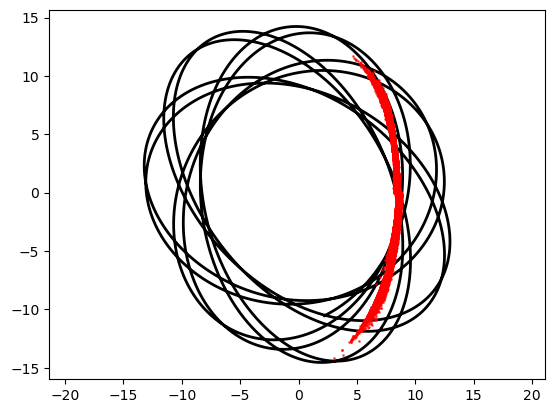

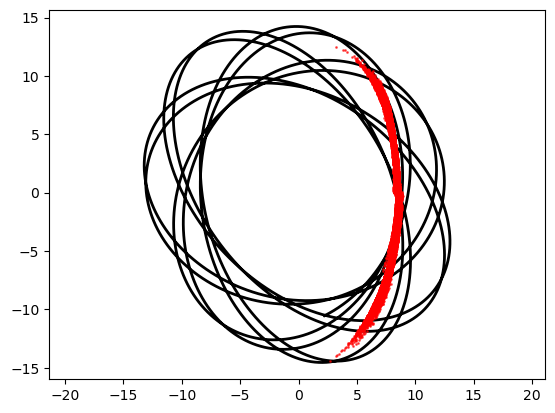

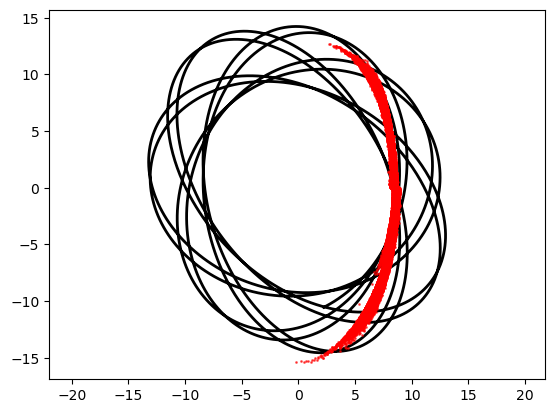

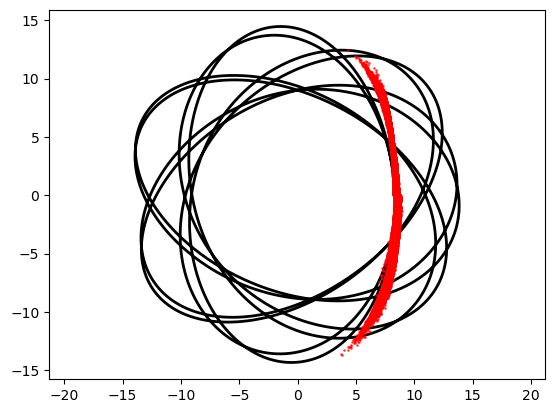

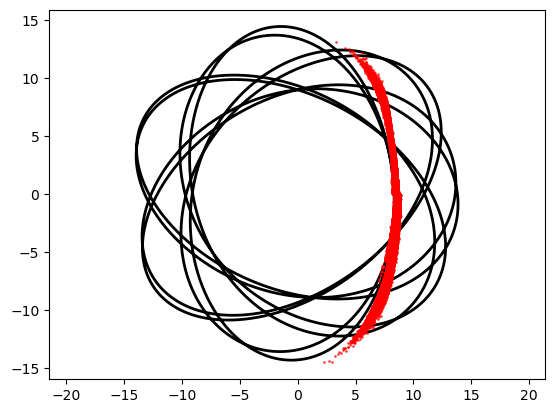

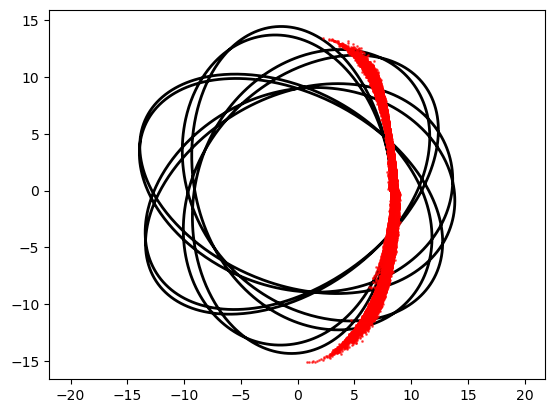

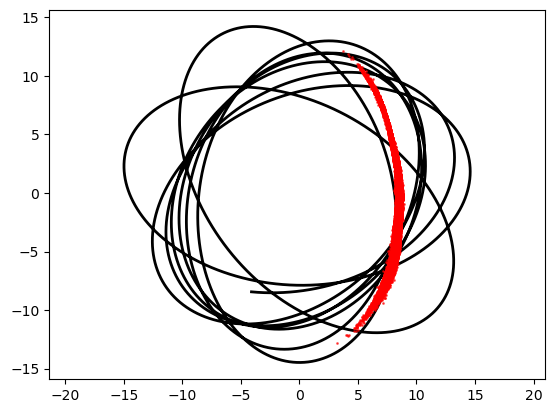

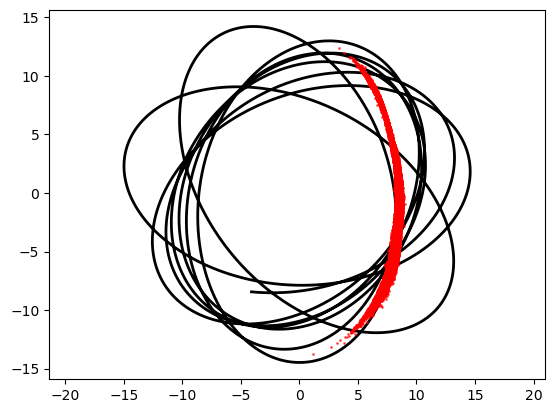

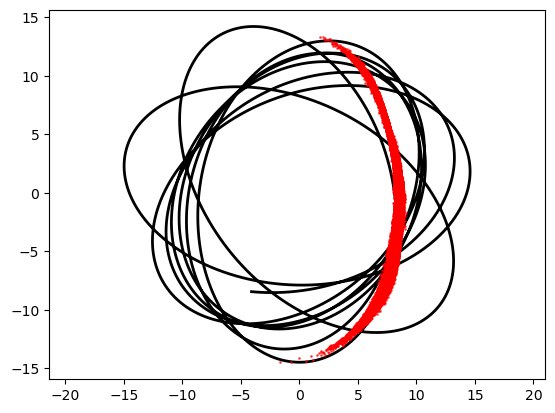

In [29]:
#plt.figure()
for i in range(len(streams)):
    
    x, y, z = streams[i]["stream"][0].pos.xyz.to_value(u.kpc)
    ox, oy, oz = streams[i]["orbit"].pos.xyz.to_value(u.kpc)
    
    plt.plot(ox, oy, color="black", lw=2, label="Progenitor orbit", zorder=-1)
    plt.scatter(x, y, s=1, alpha=0.6, c = 'r', label="Stream orbit")
    plt.axis("equal")
    plt.show()

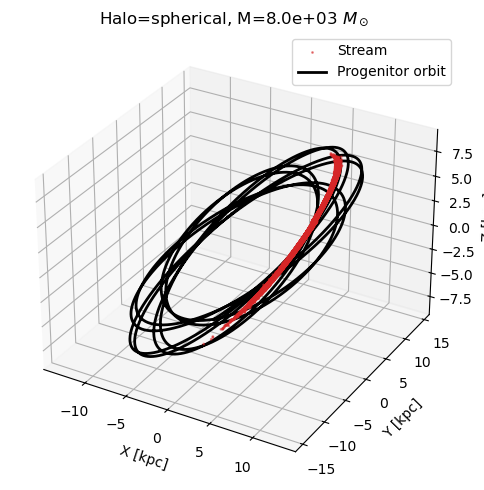

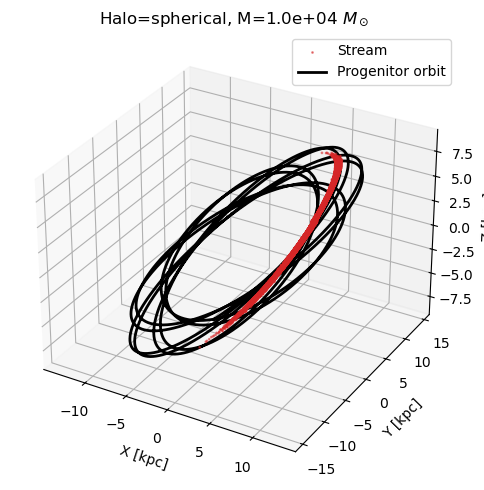

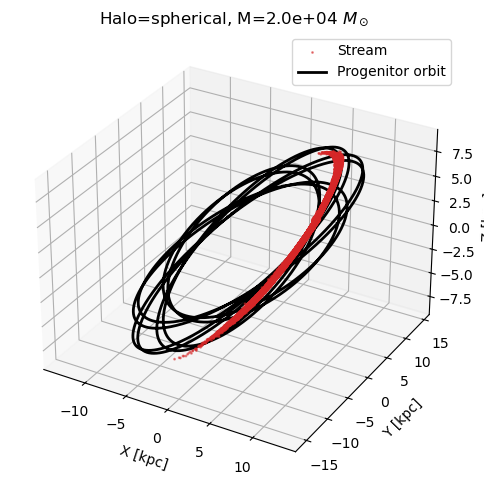

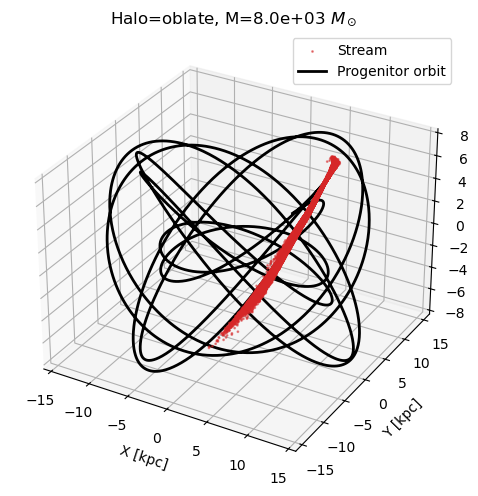

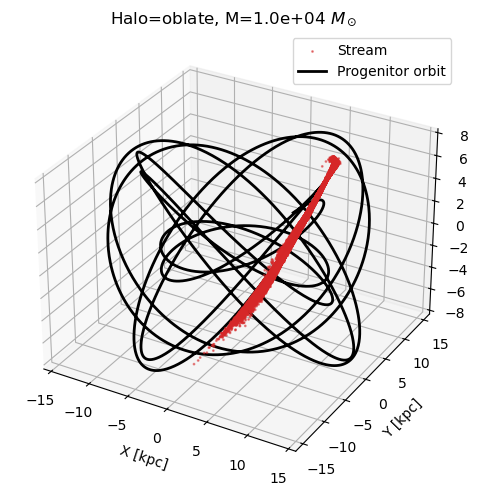

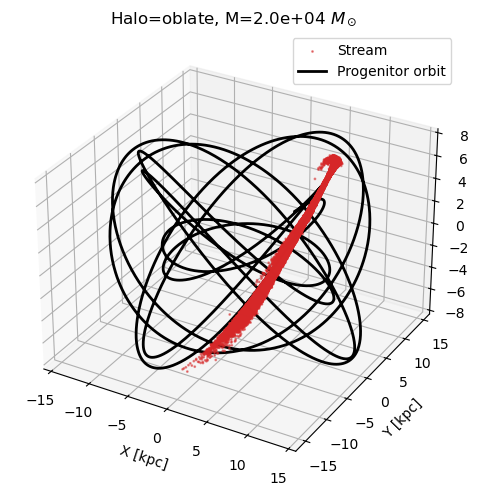

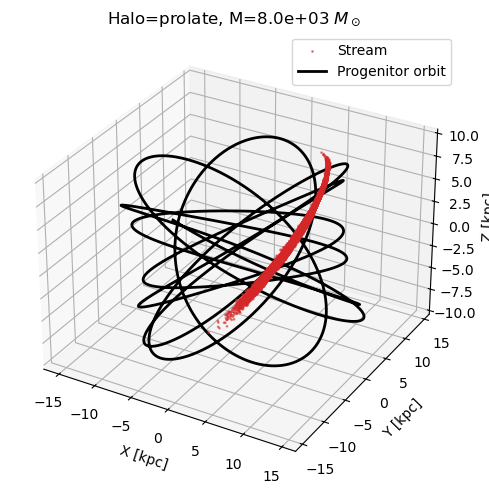

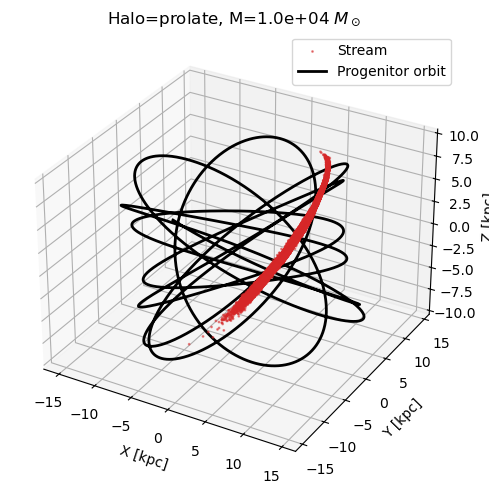

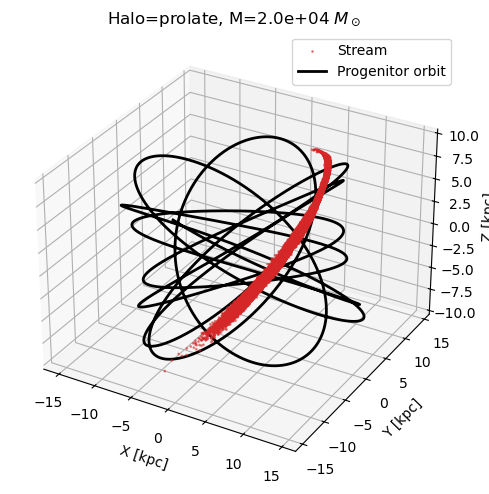

In [30]:
for i, s in enumerate(streams):

    stream = s["stream"][0]
    orbit  = s["orbit"]

    # Stream positions
    sx, sy, sz = stream.pos.xyz.to_value(u.kpc)

    # Orbit positions
    ox, oy, oz = orbit.pos.xyz.to_value(u.kpc)

    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111, projection="3d")

    ax.scatter(
        sx, sy, sz,
        s=1, alpha=0.5,
        color="tab:red",
        label="Stream"
    )

    ax.plot(
        ox, oy, oz,
        color="black",
        lw=2,
        label="Progenitor orbit",
        zorder=-1
    )

    ax.set_xlabel("X [kpc]")
    ax.set_ylabel("Y [kpc]")
    ax.set_zlabel("Z [kpc]")

    ax.set_title(
        f"Halo={s['halo']}, M={s['mass'].value:.1e} $M_\\odot$"
    )

    ax.legend()
    plt.tight_layout()
    plt.show()

In [32]:
orbit.vel.d_xyz.to_value(u.km/u.s)

array([[  0.        ,   1.80252078,   3.60766289, ..., 174.77696458,
        174.02954187, 173.25177337],
       [180.        , 179.9804629 , 179.92179355, ..., -13.0974489 ,
        -14.75314479, -16.39647345],
       [ 60.        ,  60.73181357,  61.45568817, ..., -39.16556048,
        -38.38702571, -37.60762621]])

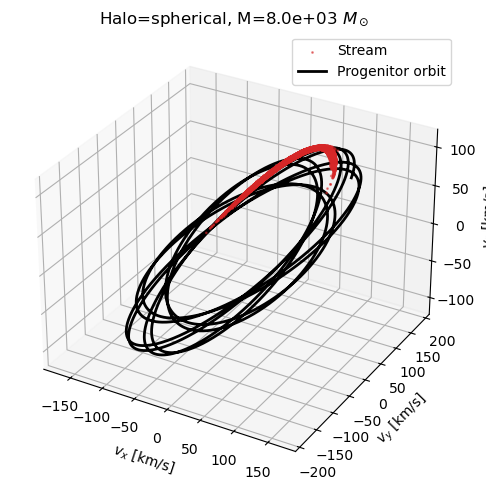

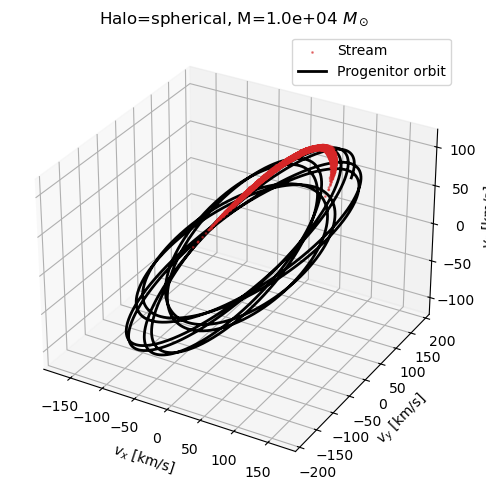

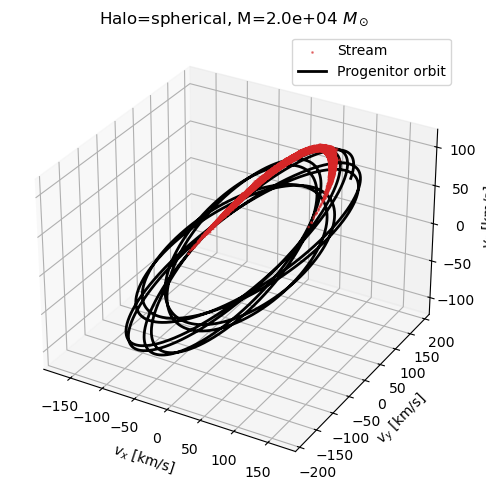

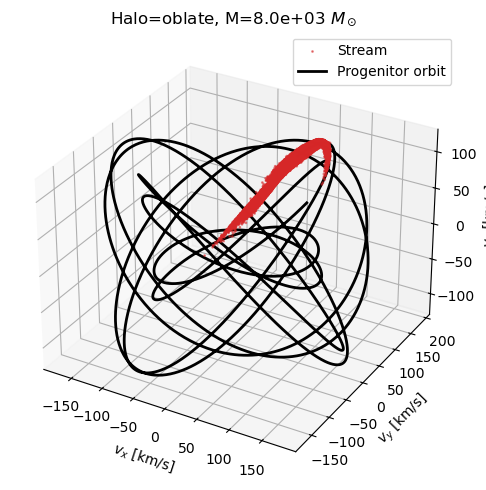

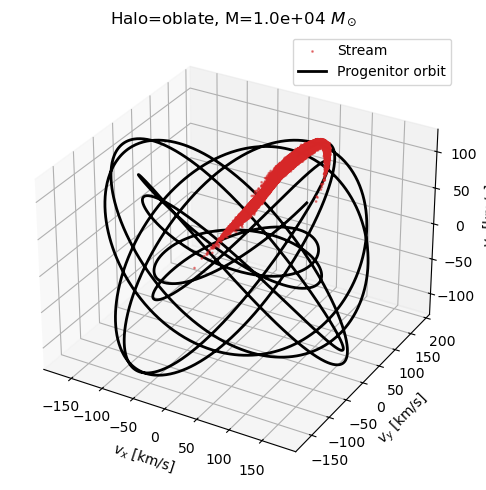

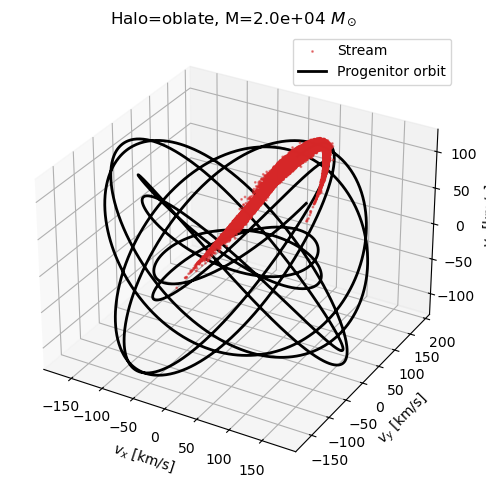

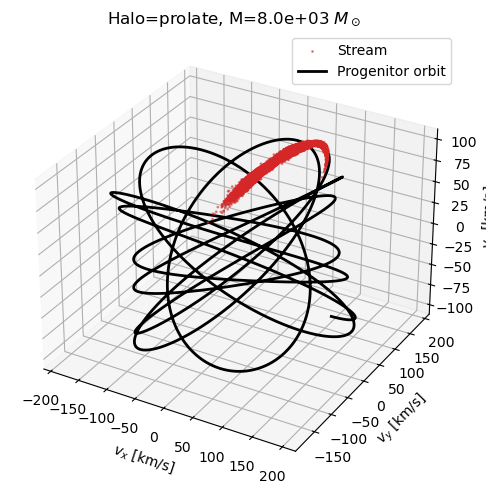

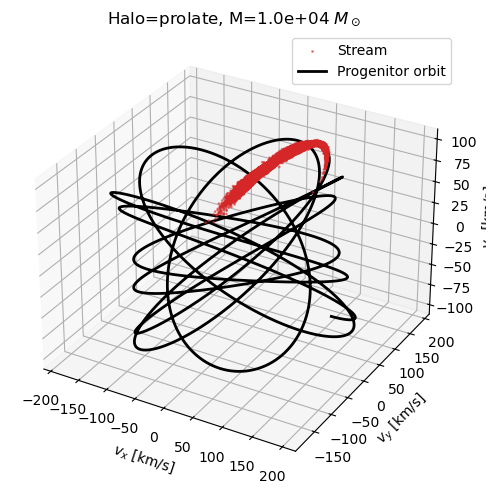

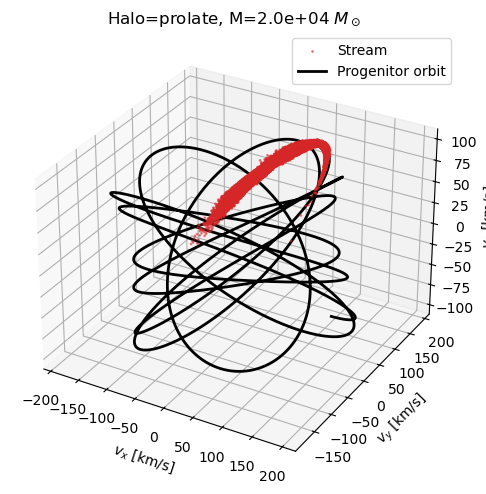

In [34]:
for i, s in enumerate(streams):

    stream = s["stream"][0]
    orbit  = s["orbit"]

    # Stream velocities
    svx, svy, svz = stream.vel.d_xyz.to_value(u.km/u.s)

    # Orbit velocities
    ovx, ovy, ovz = orbit.vel.d_xyz.to_value(u.km/u.s)

    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111, projection="3d")

    ax.scatter(
        svx, svy, svz,
        s=1, alpha=0.5,
        color="tab:red",
        label="Stream"
    )

    ax.plot(
        ovx, ovy, ovz,
        color="black",
        lw=2,
        label="Progenitor orbit",
        zorder=-1
    )

    ax.set_xlabel(r"$v_x$ [km/s]")
    ax.set_ylabel(r"$v_y$ [km/s]")
    ax.set_zlabel(r"$v_z$ [km/s]")

    ax.set_title(
        f"Halo={s['halo']}, M={s['mass'].value:.1e} $M_\\odot$"
    )

    ax.legend()
    plt.tight_layout()
    plt.show()